# Linking Writing Processes to Writing Quality Project

This project is based on the Kaggle competition [Linking Writing Processes to Writing Quality](https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality). The train data set for the competition includes scores for about 2.7k essays as well as a set of logs with thousands of records for each essay with over 8 million records total.  
  
The goal of the project is to use the data about each student's writing process to predict the score that they receive on their essay.  My project includes three notebooks: one for preprocessing, one for modeling, and a final notebook featuring only the essential elements of the previous two.

## Project Summary

<img src="Essay_DFD.png" alt=" " width="900" height="900" style="float:left; margin-right:10px;">

## Preprocessing

In this notebook, I preprocess the data for the competition.  
  
The competition data contains thousands of logs for each essay. I aggregate the logs into a single set of features for each essay to prepare for modeling. I also perform feature engineering and exploratory data analysis throughout the process. At the end of the notebook, I gather all of the preprocessing steps into a single function that I use to preprocess the data both for the modeling notebook and the Kaggle competition.  
  
Below, I include some basic information about the competition data from the Kaggle competition page to provide the business context for the project.

## Keystroke Data Collection Procedure

From [Kaggle competition page](https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality/overview)

Participants of this project were hired from Amazon Mechanical Turk, a crowdsourcing platform. They were invited to log onto a website that housed a demographic survey, a series of typing tests, an argumentative writing task, and a vocabulary knowledge test. Participants were required to use only computers with a keyboard.

During the argumentative writing task, participants were asked to write an argumentative essay within 30 minutes in response to a writing prompt adapted from a retired Scholastic Assessment Test (SAT) taken by high school students attempting to enter post-secondary institutions in the United States. To control for potential prompt effects, four SAT-based writing prompts were used and each participant was randomly assigned one prompt. Prior to the writing task, instructions were presented on the integral components in an argumentative essay (e.g., introduction, position, reasons and evidence) along with descriptions of their functions in argumentation. The instructions pages also introduced a set of rules for the writing task. These include that participants should write an essay of at least 200 words in 3 paragraphs and that they should not use any online or offline reference materials. To make sure participants stayed focused on the task during writing and to track behavior, the writing task page issued warnings whenever the participant was detected inactive for more than 2 minutes or moved to a new window in the process of writing.

## Data Description

From [Kaggle competition page](https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality/data)

**train_logs.csv** - Input logs to be used as training data. To prevent reproduction of the essay text, all alphanumeric character inputs have been replaced with the "anonymous" character q; punctuation and other special characters have not been anonymized.
  
* id - The unique ID of the essay
* event_id - The index of the event, ordered chronologically  
* down_time - The time of the down event in milliseconds  
* up_time - The time of the up event in milliseconds  
* action_time - The duration of the event (the difference between down_time and up_time)  
* activity - The category of activity which the event belongs to
* Nonproduction - The event does not alter the text in any way
* Input - The event adds text to the essay
* Remove/Cut - The event removes text from the essay
* Paste - The event changes the text through a paste input
* Replace - The event replaces a section of text with another string
* Move From [x1, y1] To [x2, y2] - The event moves a section of text spanning character index x1, y1 to a new location x2, y2
* down_event - The name of the event when the key/mouse is pressed
* up_event - The name of the event when the key/mouse is released
* text_change - The text that changed as a result of the event (if any)
* cursor_position - The character index of the text cursor after the event
* word_count - The word count of the essay after the event
    
**Note:** Key_down and key_up events may not necessarily occur in the same order as they are presented in the dataset. To illustrate, a writer may press down "a" and then press down "b" before he/she even releases "a". However, all the keystroke information about "a" comes before "b" in the dataframe.
  
**test_logs.csv** - Input logs to be used as test data. Contains the same fields as train_logs.csv. The logs available in the public version of this file are only examples to illustrate the format.  
    
**train_scores.csv**  
* id - The unique ID of the essay
* score - The score the essay received out of 6 (the prediction target for the competition)

## 1. Importing the Data and Initial Review

### 1a. Imports and Shape

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
train_df = pd.read_csv('Data/train_logs.csv')

In [3]:
train_df.shape

(8405898, 11)

In [4]:
train_scores_df = pd.read_csv('Data/train_scores.csv')

In [5]:
train_scores_df.shape

(2471, 2)

While the train logs have over 8 million records, the train scores have only about 2.5k records. That means that there are around 3k train log records for each train score record.

### 1b. Train Log Data

In [6]:
train_df.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


Looking at the head of the dataframe shows the information that is available for each essay. In general, the data includes the time and position of every mouse click and key stroke. For each of these actions, the data includes the cursor position and word count. Knowing that this data needs to be aggregated to use it with the scores, some categories could include the total action time, the number of events, the final word count, and the time spent on each activity type.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405898 entries, 0 to 8405897
Data columns (total 11 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id               object
 1   event_id         int64 
 2   down_time        int64 
 3   up_time          int64 
 4   action_time      int64 
 5   activity         object
 6   down_event       object
 7   up_event         object
 8   text_change      object
 9   cursor_position  int64 
 10  word_count       int64 
dtypes: int64(6), object(5)
memory usage: 705.5+ MB


Other than the id, there are 9 features-- a mix of object and integer data types.

In [8]:
train_df.isna().sum()

id                 0
event_id           0
down_time          0
up_time            0
action_time        0
activity           0
down_event         0
up_event           0
text_change        0
cursor_position    0
word_count         0
dtype: int64

There are no null values.

### 1c. Train Score Data

In [9]:
train_scores_df.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


In [10]:
train_scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2471 non-null   object 
 1   score   2471 non-null   float64
dtypes: float64(1), object(1)
memory usage: 38.7+ KB


This dataframe has fewer than 3,000 records and no nulls. To get a sense of the shape of the data, I create a bar plot to visualize how many essays there are for each score.

In [11]:
# Creating a variable for the value counts

score_vals = train_scores_df['score'].value_counts()

In [12]:
# Turning the series into a dataframe

score_counts = pd.DataFrame({'Score': score_vals.index, 'Number of Essays': score_vals.values})

In [13]:
# Sorting by score for the visualization

score_counts.sort_values(by='Score',inplace=True)

In [14]:
score_counts.reset_index(inplace=True,drop=True)

In [111]:
# Defining a custom color palette for the bars in the bar plot

custom_palette = ['#1768AC' if 3 <= score <= 4.5 else '#A2A7A5' for score in score_counts['Score']]

In [112]:
score_counts.loc[(score_counts['Score']<=2.5)|(score_counts['Score']>=5),'alpha'] = .5
score_counts.loc[(score_counts['Score']>=3)&(score_counts['Score']<=4.5),'alpha'] = 1

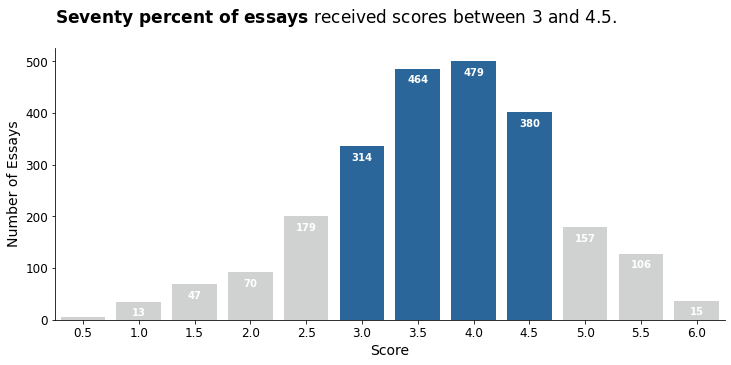

In [113]:
plt.figure(figsize=(12,5))

## Using the custom color palette to format the bar plot
ax = sns.barplot(x='Score',y='Number of Essays',palette=custom_palette,data=score_counts)

# Formatting the title
title_text = r"$\bf{" 'Seventy \ percent \ of \ essays' "}$" + " received scores between 3 and 4.5."

# Creating data labels
for p in ax.patches:
    height = (p.get_height() - 22)
    width = p.get_width()
    ax.annotate(f'{height:.0f}', (p.get_x() + width/2, height), ha='center', va='center', color='white', weight='bold')
    
# Applying different transparencies to different bars
for bar, alpha in zip(ax.containers[0], score_counts['alpha']):
    bar.set_alpha(alpha)

# Formatting labels and ticks and despining
plt.title(title_text, loc='left', pad=25, fontsize= 17)
plt.xlabel('Score', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Number of Essays', fontsize=14)
plt.yticks(fontsize=12)
sns.despine()
plt.show();

The majority of essays fall within the range of 3 to 4.5. The distribution of the scores is fairly normal.

## 2. Preparing for Modeling

In the following section, I develop a preprocessing function one category at a time to preprocess unseen data from the test set for modeling. I also perform EDA and feature engineering along the way.

In [17]:
full_df = train_scores_df.copy()

### 2a. Action Time

In [18]:
# Creating a variable for the sum of all action time

action_time_df = train_df.groupby(by='id')['action_time'].agg(['sum','mean','std','min','max']).reset_index()
action_time_df

,id,sum,mean,std,min,max
0,001519c8,297243,116.246774,91.797374,0,2259
1,0022f953,275391,112.221271,55.431189,0,1758
2,0042269b,421201,101.837766,82.383766,0,3005
3,0059420b,189596,121.848329,113.768226,0,806
4,0075873a,313702,123.943896,62.082013,0,701
...,...,...,...,...,...,...
2466,ffb8c745,499670,105.437856,63.622575,0,3323
2467,ffbef7e5,214221,82.266129,36.178818,0,1144
2468,ffccd6fd,231580,75.605615,63.494975,0,564
2469,ffec5b38,289439,89.277915,54.515788,0,1388


In [19]:
# Turning the Series into a DataFrame

action_time_df.columns = ['id', 'sum_action_time', 'mean_action_time', 'std_action_time', 'min_action_time', 'max_action_time']
action_time_df

,id,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time
0,001519c8,297243,116.246774,91.797374,0,2259
1,0022f953,275391,112.221271,55.431189,0,1758
2,0042269b,421201,101.837766,82.383766,0,3005
3,0059420b,189596,121.848329,113.768226,0,806
4,0075873a,313702,123.943896,62.082013,0,701
...,...,...,...,...,...,...
2466,ffb8c745,499670,105.437856,63.622575,0,3323
2467,ffbef7e5,214221,82.266129,36.178818,0,1144
2468,ffccd6fd,231580,75.605615,63.494975,0,564
2469,ffec5b38,289439,89.277915,54.515788,0,1388


In [20]:
# Calculating time given for assignment in milliseconds

30 * 60 * 1000

1800000

In [21]:
# Translating the milliseconds into seconds for interpretability

action_time_df['action_time_%_total'] = action_time_df['sum_action_time'] / 1800000

In [22]:
action_time_df.sort_values(by = 'action_time_%_total')

,id,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time,action_time_%_total
1562,a50ad9b8,13452,8.423294,38.642843,0,673,0.007473
851,5a3f0d07,17541,66.950382,22.354027,23,208,0.009745
1735,b61221f1,19629,14.131749,24.191105,0,172,0.010905
295,1dc5440c,27303,15.442873,38.582878,0,498,0.015168
1416,95acfe17,27858,65.241218,23.281103,7,269,0.015477
...,...,...,...,...,...,...,...
2018,d3fef198,950927,73.852672,37.220109,0,882,0.528293
2420,fb2cb7e6,951659,129.301495,113.117859,0,3716,0.528699
500,347a3473,959581,117.179265,44.476954,0,569,0.533101
1640,ad5f7cbb,1043640,194.781635,243.665571,0,9999,0.579800


The lowest action time was 13 seconds and the highest was 1210 seconds, or about 20 minutes. Action time measures the full duration between down event and up event. It is not a complete measure of overall productivity, but it should at least generally point towards how active each essay writer was.

In [23]:
# Merging the new features into full_df

full_df = pd.merge(full_df, action_time_df, on='id')

In [24]:
full_df

,id,score,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time,action_time_%_total
0,001519c8,3.5,297243,116.246774,91.797374,0,2259,0.165135
1,0022f953,3.5,275391,112.221271,55.431189,0,1758,0.152995
2,0042269b,6.0,421201,101.837766,82.383766,0,3005,0.234001
3,0059420b,2.0,189596,121.848329,113.768226,0,806,0.105331
4,0075873a,4.0,313702,123.943896,62.082013,0,701,0.174279
...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,105.437856,63.622575,0,3323,0.277594
2467,ffbef7e5,4.0,214221,82.266129,36.178818,0,1144,0.119012
2468,ffccd6fd,1.5,231580,75.605615,63.494975,0,564,0.128656
2469,ffec5b38,5.0,289439,89.277915,54.515788,0,1388,0.160799


In [25]:
viz_data = full_df[['score','sum_action_time']]
viz_data['action_time_mins'] = viz_data['sum_action_time'] / 60000
viz_data

<ipython-input-25-7a5a687f046b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz_data['action_time_mins'] = viz_data['sum_action_time'] / 60000


,score,sum_action_time,action_time_mins
0,3.5,297243,4.954050
1,3.5,275391,4.589850
2,6.0,421201,7.020017
3,2.0,189596,3.159933
4,4.0,313702,5.228367
...,...,...,...
2466,3.5,499670,8.327833
2467,4.0,214221,3.570350
2468,1.5,231580,3.859667
2469,5.0,289439,4.823983


In [26]:
viz_series = viz_data.groupby('score')['action_time_mins'].median()

In [27]:
viz_df = pd.DataFrame({'score':viz_series.index,'median_action_mins':viz_series.values})

In [28]:
viz_df.loc[viz_df['score']>=5.5,'alpha'] = 1
viz_df.loc[viz_df['score']<=5,'alpha'] = .5

In [29]:
# Defining a custom color palette for the bars in the bar plot

custom_palette = ['#1768AC' if score >= 2.5 else '#A2A7A5' for score in viz_df['score']]

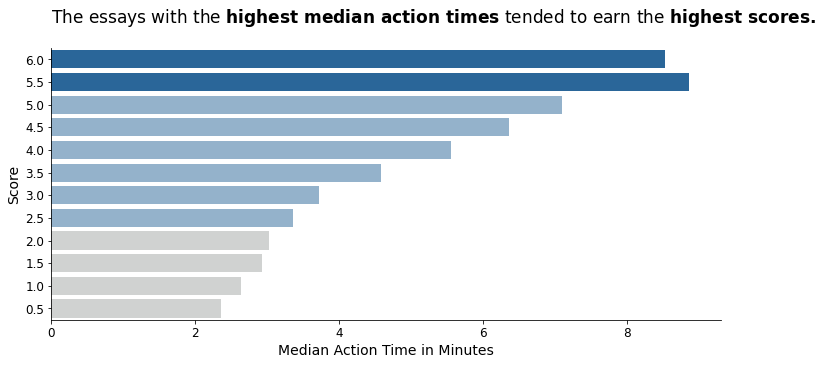

In [30]:
plt.figure(figsize=(12,5))

## Using the custom color palette to format the bar plot

ax = sns.barplot(x='median_action_mins', y='score', data=viz_df, palette=custom_palette, orient='h', ci=None)

plt.gca().invert_yaxis()

# Applying different transparencies to different bars
for bar, alpha in zip(ax.containers[0], viz_df['alpha']):
    bar.set_alpha(alpha)
    
# Formatting the title and subtitle
title_text = "The essays with the " + r"$\bf{" 'highest \ median \ action \ times' "}$" + " tended to earn the " + r"$\bf{" 'highest \ scores.' "}$"
plt.title(title_text, loc='left', pad=25, fontsize= 17)

# Formatting final attributes
plt.xlabel('Median Action Time in Minutes', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Score', fontsize=14)
plt.yticks(fontsize=12)
sns.despine()
plt.show();

### 2b. Word Count

For the word count category, I start by finding the index for the final record for each essay and taking the word count. Then, I calculate the overall words produced and create a ratio to point towards the amount of revision that occured.

In [31]:
# Finding the final word count for each essay

final_word_count = train_df.groupby('id')['word_count'].last()

In [32]:
final_word_count

id
001519c8    255
0022f953    320
0042269b    404
0059420b    206
0075873a    252
           ... 
ffb8c745    273
ffbef7e5    438
ffccd6fd    201
ffec5b38    413
fff05981    240
Name: word_count, Length: 2471, dtype: int64

In [33]:
# Turning the Series into a DataFrame

word_count_df = pd.DataFrame({'id':final_word_count.index,'word_count':final_word_count.values})

Now, I calculate the overall words produced for each essay.

In [34]:
# Finding the final event id for each essay

final_record_id_series = train_df.groupby('id')['event_id'].last()
final_record_ids = final_record_id_series.to_dict()

In [35]:
# Calculating total words for each group

def total_words(group):
    
    # Get the final record ID for each group
    final_record_id = final_record_ids[group.name]
    
    # Calculating the overall word count increase
    word_counts = group[group['event_id'] <= final_record_id]['word_count']
    word_diffs = word_counts.diff().where(lambda x: x > 0).sum()  
    
    return word_diffs

In [36]:
# Applying the function to calculate total word count for each essay

total_words = train_df.groupby('id').apply(total_words)
total_words

id
001519c8    348.0
0022f953    369.0
0042269b    549.0
0059420b    244.0
0075873a    339.0
            ...  
ffb8c745    620.0
ffbef7e5    450.0
ffccd6fd    213.0
ffec5b38    472.0
fff05981    408.0
Length: 2471, dtype: float64

In [37]:
# Merging total words into word count df

total_words_df = pd.DataFrame({'id':total_words.index,'total_words':total_words.values})
word_count_df = pd.merge(word_count_df, total_words_df, on='id')
word_count_df

,id,word_count,total_words
0,001519c8,255,348.0
1,0022f953,320,369.0
2,0042269b,404,549.0
3,0059420b,206,244.0
4,0075873a,252,339.0
...,...,...,...
2466,ffb8c745,273,620.0
2467,ffbef7e5,438,450.0
2468,ffccd6fd,201,213.0
2469,ffec5b38,413,472.0


Finally, I calculate a ratio of the word_count relative to the total words produced. This should point towards how much revision happened during the writing process.

In [38]:
word_count_df['word_count_%_total'] = word_count_df['word_count'] / word_count_df['total_words']

In [39]:
word_count_df.sort_values(by='word_count_%_total')

,id,word_count,total_words,word_count_%_total
1760,b8a857fc,409,1950.0,0.209744
784,52bec922,122,473.0,0.257928
1685,b1789fc6,212,811.0,0.261406
1264,84957285,266,960.0,0.277083
838,581eaf19,202,664.0,0.304217
...,...,...,...,...
1021,6b0cfb58,584,589.0,0.991511
925,62b9a12b,563,566.0,0.994700
2313,f08f6465,204,205.0,0.995122
1773,ba001912,259,260.0,0.996154


The essay with the lowest ratio of final word count to total words cut about 80% of the overall words that the author produced during the writing time. On the other end of the data, a few authors cut only a single word for their final pieces.

In [40]:
# Merging into the full dataframe

full_df = pd.merge(full_df,word_count_df,on='id')
full_df

,id,score,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time,action_time_%_total,word_count,total_words,word_count_%_total
0,001519c8,3.5,297243,116.246774,91.797374,0,2259,0.165135,255,348.0,0.732759
1,0022f953,3.5,275391,112.221271,55.431189,0,1758,0.152995,320,369.0,0.867209
2,0042269b,6.0,421201,101.837766,82.383766,0,3005,0.234001,404,549.0,0.735883
3,0059420b,2.0,189596,121.848329,113.768226,0,806,0.105331,206,244.0,0.844262
4,0075873a,4.0,313702,123.943896,62.082013,0,701,0.174279,252,339.0,0.743363
...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,105.437856,63.622575,0,3323,0.277594,273,620.0,0.440323
2467,ffbef7e5,4.0,214221,82.266129,36.178818,0,1144,0.119012,438,450.0,0.973333
2468,ffccd6fd,1.5,231580,75.605615,63.494975,0,564,0.128656,201,213.0,0.943662
2469,ffec5b38,5.0,289439,89.277915,54.515788,0,1388,0.160799,413,472.0,0.875000


In [41]:
wc_viz_df = full_df.groupby('score').median()
wc_viz_df.reset_index(inplace=True)
wc_viz_df = wc_viz_df[['score','word_count','total_words','word_count_%_total']]
wc_viz_df

,score,word_count,total_words,word_count_%_total
0,0.5,216.0,233.0,0.952607
1,1.0,211.0,234.0,0.911392
2,1.5,219.0,255.0,0.913242
3,2.0,213.0,241.0,0.900657
4,2.5,224.0,269.0,0.870229
5,3.0,255.0,307.5,0.869798
6,3.5,305.5,387.0,0.847571
7,4.0,374.0,471.0,0.844444
8,4.5,463.5,563.0,0.851727
9,5.0,519.0,641.0,0.855959


In [42]:
wc_viz_df.loc[viz_df['score']>=5.5,'wc_alpha'] = 1
wc_viz_df.loc[viz_df['score']<=5,'wc_alpha'] = .5

In [43]:
# Defining a custom color palette for the bars in the bar plot

wc_custom_palette = ['#1768AC' if score >= 3 else '#A2A7A5' for score in viz_df['score']]

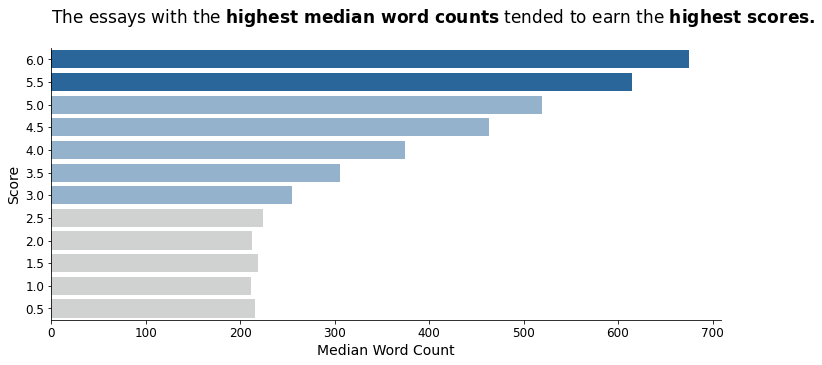

In [44]:
plt.figure(figsize = (12,5))
ax = sns.barplot(x='word_count',y='score',data=wc_viz_df,orient='h',palette=wc_custom_palette)

# Inverting y axis values
plt.gca().invert_yaxis()

# Applying different transparencies to different bars
for bar, alpha in zip(ax.containers[0], wc_viz_df['wc_alpha']):
    bar.set_alpha(alpha)
    
# Formatting the title and subtitle
title_text = "The essays with the " + r"$\bf{" 'highest \ median \ word \ counts' "}$" + " tended to earn the " + r"$\bf{" 'highest \ scores.' "}$"
plt.title(title_text, loc='left', pad=25, fontsize= 17)    

# Formatting final attributes
plt.xlabel('Median Word Count', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Score', fontsize=14)
plt.yticks(fontsize=12)    
sns.despine()
plt.show();

In [45]:
wc_viz_df['%_words_removed'] = 1 - wc_viz_df['word_count_%_total']

In [122]:
wc_viz_df.loc[(viz_df['score']>=2.5)|(viz_df['score']==.5),'wr_alpha'] = .3
wc_viz_df.loc[(viz_df['score']<=2)&(viz_df['score']>=1),'wr_alpha'] = 1

In [123]:
# Defining a custom color palette for the bars in the bar plot

wr_custom_palette = ['#F9A620' if score <= 2 else '#A2A7A5' for score in viz_df['score']]

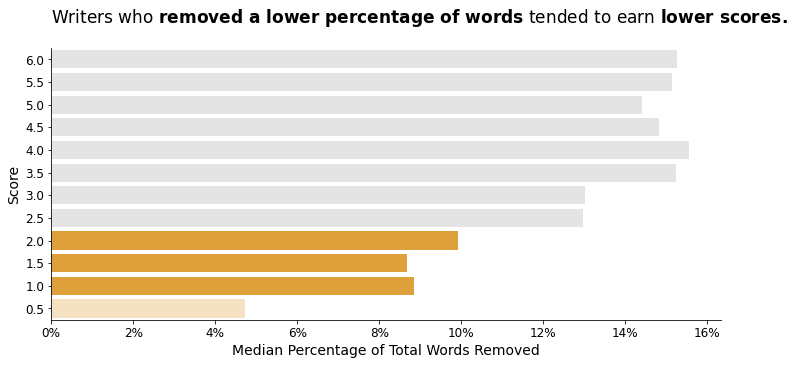

In [125]:
plt.figure(figsize = (12,5))
ax = sns.barplot(x='%_words_removed',y='score',data=wc_viz_df,orient='h',palette=wr_custom_palette)

plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

# Applying different transparencies to different bars
for bar, alpha in zip(ax.containers[0], wc_viz_df['wr_alpha']):
    bar.set_alpha(alpha)
    
# Formatting the title and subtitle
title_text = 'Writers who ' + r"$\bf{" 'removed \ a \ lower \ percentage \ of \ words' "}$" + ' tended to earn ' + r"$\bf{" 'lower \ scores.' "}$"
plt.title(title_text, loc='left', pad=25, fontsize= 17)    

# Formatting final attributes
plt.xlabel('Median Percentage of Total Words Removed', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Score', fontsize=14)
plt.yticks(fontsize=12)    
sns.despine()
plt.show();

### 2c. Event Count

For event count, I find the final event count for each essay.

In [49]:
event_count = train_df.groupby('id')['event_id'].last()

In [50]:
event_count_df = pd.DataFrame({'id':event_count.index,'event_count':event_count.values})

In [51]:
full_df = pd.merge(full_df,event_count_df,on='id')
full_df

,id,score,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time,action_time_%_total,word_count,total_words,word_count_%_total,event_count
0,001519c8,3.5,297243,116.246774,91.797374,0,2259,0.165135,255,348.0,0.732759,2557
1,0022f953,3.5,275391,112.221271,55.431189,0,1758,0.152995,320,369.0,0.867209,2454
2,0042269b,6.0,421201,101.837766,82.383766,0,3005,0.234001,404,549.0,0.735883,4136
3,0059420b,2.0,189596,121.848329,113.768226,0,806,0.105331,206,244.0,0.844262,1556
4,0075873a,4.0,313702,123.943896,62.082013,0,701,0.174279,252,339.0,0.743363,2531
...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,105.437856,63.622575,0,3323,0.277594,273,620.0,0.440323,4739
2467,ffbef7e5,4.0,214221,82.266129,36.178818,0,1144,0.119012,438,450.0,0.973333,2604
2468,ffccd6fd,1.5,231580,75.605615,63.494975,0,564,0.128656,201,213.0,0.943662,3063
2469,ffec5b38,5.0,289439,89.277915,54.515788,0,1388,0.160799,413,472.0,0.875000,3242


In [52]:
event_viz_series = full_df.groupby('score')['event_count'].median()

In [53]:
event_viz_df = pd.DataFrame({'score':event_viz_series.index,'event_count':event_viz_series.values})

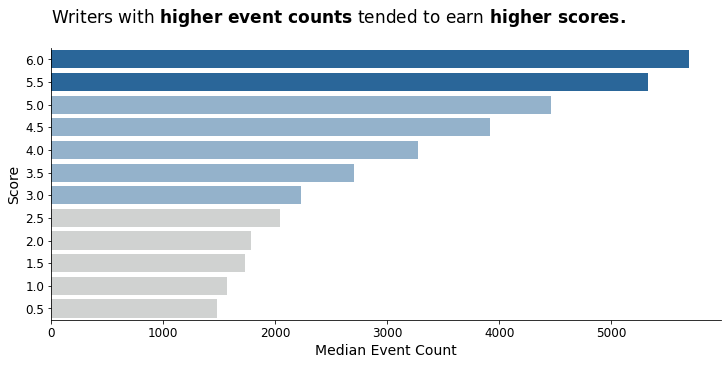

In [54]:
plt.figure(figsize = (12,5))
ax = sns.barplot(x='event_count',y='score',data=event_viz_df,orient='h',palette=wc_custom_palette)

# Inverting y axis values
plt.gca().invert_yaxis()

# Applying different transparencies to different bars
for bar, alpha in zip(ax.containers[0], wc_viz_df['wc_alpha']):
    bar.set_alpha(alpha)
    
# Formatting the title and subtitle
r"$\bf{" 'highest \ median \ word \ counts' "}$"
title_text = "Writers with " + r"$\bf{" 'higher \ event \ counts' "}$" + " tended to earn " + r"$\bf{" 'higher \ scores.' "}$"
plt.title(title_text, loc='left', pad=25, fontsize= 17)    

# Formatting final attributes
plt.xlabel('Median Event Count', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Score', fontsize=14)
plt.yticks(fontsize=12)    
sns.despine()
plt.show();

### 2d. Activity

For activity, there is some data cleaning to do around the move activities. Then, I calculate how many events are dedicated to each activity as well as a ratio of the number of events per activity relative to the total event count.

In [55]:
train_df['activity'].value_counts()

Input                                     6726796
Remove/Cut                                 970158
Nonproduction                              703851
Replace                                      4448
Paste                                         599
Move From [1306, 1371] To [1061, 1126]          2
Move From [134, 169] To [122, 157]              1
Move From [1041, 1121] To [1496, 1576]          1
Move From [1386, 1450] To [1445, 1509]          1
Move From [213, 302] To [902, 991]              1
Move From [999, 1000] To [1000, 1001]           1
Move From [1861, 2063] To [1766, 1968]          1
Move From [382, 437] To [458, 513]              1
Move From [1144, 1147] To [1142, 1145]          1
Move From [186, 187] To [184, 185]              1
Move From [114, 140] To [272, 298]              1
Move From [408, 414] To [390, 396]              1
Move From [0, 75] To [1, 76]                    1
Move From [1651, 1769] To [1565, 1683]          1
Move From [905, 1314] To [907, 1316]            1


In [56]:
# Cleaning the different kinds of Move events

train_df.loc[train_df['activity'].str.contains('From',case=False), 'activity'] = 'Move'

In [57]:
train_df['activity'].value_counts()

Input            6726796
Remove/Cut        970158
Nonproduction     703851
Replace             4448
Paste                599
Move                  46
Name: activity, dtype: int64

In [58]:
# Finding the counts for each activity type

activity_df = train_df.groupby(by='id')['activity'].value_counts().unstack(fill_value=0)

In [59]:
activity_df

activity,Input,Move,Nonproduction,Paste,Remove/Cut,Replace
id,,,,,,
001519c8,2010,3,120,0,417,7
0022f953,1938,0,254,1,260,1
0042269b,3515,0,175,0,439,7
0059420b,1304,0,99,1,151,1
0075873a,1942,0,72,0,517,0
...,...,...,...,...,...,...
ffb8c745,3588,0,189,0,960,2
ffbef7e5,2395,0,148,0,60,1
ffccd6fd,2849,0,126,0,88,0


In [60]:
activity_df.reset_index(inplace=True)

In [61]:
# Merging with the full dataframe

full_df = pd.merge(full_df,activity_df,on='id')
full_df

,id,score,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time,action_time_%_total,word_count,total_words,word_count_%_total,event_count,Input,Move,Nonproduction,Paste,Remove/Cut,Replace
0,001519c8,3.5,297243,116.246774,91.797374,0,2259,0.165135,255,348.0,0.732759,2557,2010,3,120,0,417,7
1,0022f953,3.5,275391,112.221271,55.431189,0,1758,0.152995,320,369.0,0.867209,2454,1938,0,254,1,260,1
2,0042269b,6.0,421201,101.837766,82.383766,0,3005,0.234001,404,549.0,0.735883,4136,3515,0,175,0,439,7
3,0059420b,2.0,189596,121.848329,113.768226,0,806,0.105331,206,244.0,0.844262,1556,1304,0,99,1,151,1
4,0075873a,4.0,313702,123.943896,62.082013,0,701,0.174279,252,339.0,0.743363,2531,1942,0,72,0,517,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,105.437856,63.622575,0,3323,0.277594,273,620.0,0.440323,4739,3588,0,189,0,960,2
2467,ffbef7e5,4.0,214221,82.266129,36.178818,0,1144,0.119012,438,450.0,0.973333,2604,2395,0,148,0,60,1
2468,ffccd6fd,1.5,231580,75.605615,63.494975,0,564,0.128656,201,213.0,0.943662,3063,2849,0,126,0,88,0
2469,ffec5b38,5.0,289439,89.277915,54.515788,0,1388,0.160799,413,472.0,0.875000,3242,2895,0,71,0,276,0


In [62]:
# Calculating action time for each activity type

pivot = train_df.pivot_table(values='action_time', index='id', columns='activity', aggfunc=['sum']).fillna(0)

In [63]:
pivot.columns = pivot.columns.droplevel(level=0)
new_columns = [col + '_time' for col in pivot.columns]
pivot.columns = new_columns
pivot['id'] = pivot.index
pivot.reset_index(drop=True,inplace=True)
pivot

,Input_time,Move_time,Nonproduction_time,Paste_time,Remove/Cut_time,Replace_time,id
0,243731.0,0.0,18506.0,0.0,34130.0,876.0,001519c8
1,237891.0,0.0,13781.0,71.0,23550.0,98.0,0022f953
2,353718.0,0.0,33951.0,0.0,32905.0,627.0,0042269b
3,167790.0,0.0,3062.0,160.0,18410.0,174.0,0059420b
4,266515.0,0.0,6988.0,0.0,40199.0,0.0,0075873a
...,...,...,...,...,...,...,...
2466,426990.0,0.0,5203.0,0.0,67253.0,224.0,ffb8c745
2467,203403.0,0.0,6583.0,0.0,4118.0,117.0,ffbef7e5
2468,214677.0,0.0,10232.0,0.0,6671.0,0.0,ffccd6fd
2469,263216.0,0.0,5624.0,0.0,20599.0,0.0,ffec5b38


In [64]:
full_df=pd.merge(full_df,pivot,on='id')

In [65]:
full_df

,id,score,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time,action_time_%_total,word_count,total_words,...,Nonproduction,Paste,Remove/Cut,Replace,Input_time,Move_time,Nonproduction_time,Paste_time,Remove/Cut_time,Replace_time
0,001519c8,3.5,297243,116.246774,91.797374,0,2259,0.165135,255,348.0,...,120,0,417,7,243731.0,0.0,18506.0,0.0,34130.0,876.0
1,0022f953,3.5,275391,112.221271,55.431189,0,1758,0.152995,320,369.0,...,254,1,260,1,237891.0,0.0,13781.0,71.0,23550.0,98.0
2,0042269b,6.0,421201,101.837766,82.383766,0,3005,0.234001,404,549.0,...,175,0,439,7,353718.0,0.0,33951.0,0.0,32905.0,627.0
3,0059420b,2.0,189596,121.848329,113.768226,0,806,0.105331,206,244.0,...,99,1,151,1,167790.0,0.0,3062.0,160.0,18410.0,174.0
4,0075873a,4.0,313702,123.943896,62.082013,0,701,0.174279,252,339.0,...,72,0,517,0,266515.0,0.0,6988.0,0.0,40199.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,105.437856,63.622575,0,3323,0.277594,273,620.0,...,189,0,960,2,426990.0,0.0,5203.0,0.0,67253.0,224.0
2467,ffbef7e5,4.0,214221,82.266129,36.178818,0,1144,0.119012,438,450.0,...,148,0,60,1,203403.0,0.0,6583.0,0.0,4118.0,117.0
2468,ffccd6fd,1.5,231580,75.605615,63.494975,0,564,0.128656,201,213.0,...,126,0,88,0,214677.0,0.0,10232.0,0.0,6671.0,0.0
2469,ffec5b38,5.0,289439,89.277915,54.515788,0,1388,0.160799,413,472.0,...,71,0,276,0,263216.0,0.0,5624.0,0.0,20599.0,0.0


In [66]:
# Calculating ratios

full_df['Move_Ratio'] = full_df['Move'] / full_df['event_count']
full_df['Paste_Ratio'] = full_df['Paste'] / full_df['event_count']
full_df['Replace_Ratio'] = full_df['Replace'] / full_df['event_count']
full_df['Nonproduction_Ratio'] = full_df['Nonproduction'] / full_df['event_count']
full_df['Remove_Ratio'] = full_df['Remove/Cut'] / full_df['event_count']
full_df['Input_Ratio'] = full_df['Input'] / full_df['event_count']
full_df['revision_events'] = full_df['Move'] + full_df['Paste'] + full_df['Replace'] + full_df['Remove/Cut']
full_df['Revision_Ratio'] =  full_df['revision_events'] / full_df['event_count']

full_df['Move_Time_Ratio'] = full_df['Move_time'] / full_df['sum_action_time']
full_df['Paste_Time_Ratio'] = full_df['Paste_time'] / full_df['sum_action_time']
full_df['Replace_Time_Ratio'] = full_df['Replace_time'] / full_df['sum_action_time']
full_df['Nonproduction_Time_Ratio'] = full_df['Nonproduction_time'] / full_df['sum_action_time']
full_df['Remove_Time_Ratio'] = full_df['Remove/Cut_time'] / full_df['sum_action_time']
full_df['Input_Time_Ratio'] = full_df['Input_time'] / full_df['sum_action_time']
full_df['revision_time'] = full_df['Move_time'] + full_df['Paste_time'] + full_df['Replace_time'] + full_df['Remove/Cut_time']
full_df['Revision_Time_Ratio'] =  full_df['revision_time'] / full_df['sum_action_time']

In [67]:
act_viz_data = full_df.groupby('score').mean()

In [68]:
act_viz_data.reset_index(inplace=True)
act_viz_df = act_viz_data[['score','Revision_Time_Ratio','Nonproduction_Time_Ratio','Input_Time_Ratio']]

In [69]:
act_viz_df['Rev_Non_Time'] = act_viz_df['Revision_Time_Ratio'] + act_viz_df['Nonproduction_Time_Ratio']
act_viz_df['Rev_Non_In_Time'] = act_viz_df['Rev_Non_Time'] + act_viz_df['Input_Time_Ratio']
act_viz_df

<ipython-input-69-a00ce1940e31>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  act_viz_df['Rev_Non_Time'] = act_viz_df['Revision_Time_Ratio'] + act_viz_df['Nonproduction_Time_Ratio']
<ipython-input-69-a00ce1940e31>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  act_viz_df['Rev_Non_In_Time'] = act_viz_df['Rev_Non_Time'] + act_viz_df['Input_Time_Ratio']


,score,Revision_Time_Ratio,Nonproduction_Time_Ratio,Input_Time_Ratio,Rev_Non_Time,Rev_Non_In_Time
0,0.5,0.045402,0.039178,0.915420,0.084580,1.0
1,1.0,0.074742,0.055312,0.869946,0.130054,1.0
2,1.5,0.078389,0.057026,0.864585,0.135415,1.0
3,2.0,0.091211,0.057380,0.851409,0.148591,1.0
4,2.5,0.091532,0.063927,0.844541,0.155459,1.0
5,3.0,0.089933,0.051252,0.858814,0.141186,1.0
6,3.5,0.089832,0.053104,0.857063,0.142937,1.0
7,4.0,0.085498,0.059277,0.855226,0.144774,1.0
8,4.5,0.088730,0.044917,0.866353,0.133647,1.0
9,5.0,0.082922,0.046187,0.870892,0.129108,1.0


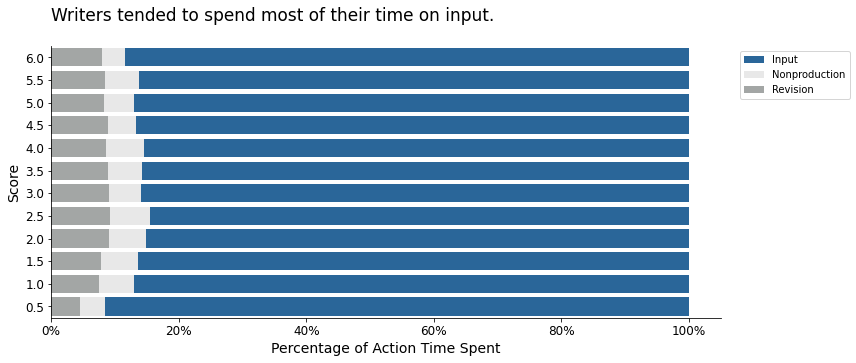

In [118]:
fig, ax = plt.subplots(figsize=(12, 5))

# Plotting the bars
sns.barplot(x='Rev_Non_In_Time', y='score', data=act_viz_df, orient='h', color='#1768AC',label='Input', ax=ax)
sns.barplot(x='Rev_Non_Time', y='score', data=act_viz_df, orient='h', color='#E8E8E8', label='Nonproduction', ax=ax)
sns.barplot(x='Revision_Time_Ratio', y='score', data=act_viz_df, orient='h', color='#A2A7A5', label='Revision', ax=ax) 

# Inverting the y-axis
plt.gca().invert_yaxis()

# Formating the x-axis as percentages
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

# Adding a legend
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')

# Formatting the title and subtitle
title_text = "Writers tended to spend most of their time on input."
plt.title(title_text, loc='left', pad=25, fontsize=17)

# Formatting final attributes
plt.xlabel('Percentage of Action Time Spent', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Score', fontsize=14)
plt.yticks(fontsize=12)
sns.despine()

plt.show()

### 2e. Time of First Input

For this field, I identify the time of the first and last inputs to see how much time each writer takes before getting started as well as how much time each author leaves on the clock at the end.

In [71]:
# Finding first input records for each essay

first_input = train_df[train_df['activity'] == 'Input'].groupby('id').first()

In [72]:
# Creating first input dataframe

first_input_df = pd.DataFrame({'id':first_input.index,'first_input':first_input['down_time']})

In [73]:
first_input_df.reset_index(drop=True,inplace=True)

In [74]:
first_input_df

,id,first_input
0,001519c8,106686
1,0022f953,32706
2,0042269b,21335
3,0059420b,161494
4,0075873a,94454
...,...,...
2466,ffb8c745,28030
2467,ffbef7e5,40574
2468,ffccd6fd,39919
2469,ffec5b38,27617


In [75]:
# Finding last input records for each essay

last_input = train_df[train_df['activity'] == 'Input'].groupby('id').last()

In [76]:
# Creating last input dataframe

last_input_df = pd.DataFrame({'id':last_input.index,'last_input':last_input['up_time']})

In [77]:
last_input_df.reset_index(drop=True,inplace=True)

In [78]:
# Merging first and last input dfs

first_last_input_df = pd.merge(first_input_df,last_input_df,on='id')

first_last_input_df = pd.merge(first_input_df,last_input_df,on='id')

In [79]:
# Merging with full df

full_df = pd.merge(full_df,first_last_input_df, on='id')
full_df

,id,score,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time,action_time_%_total,word_count,total_words,...,Move_Time_Ratio,Paste_Time_Ratio,Replace_Time_Ratio,Nonproduction_Time_Ratio,Remove_Time_Ratio,Input_Time_Ratio,revision_time,Revision_Time_Ratio,first_input,last_input
0,001519c8,3.5,297243,116.246774,91.797374,0,2259,0.165135,255,348.0,...,0.000000,0.000000,0.002947,0.062259,0.114822,0.819972,35006.0,0.117769,106686,1782985
1,0022f953,3.5,275391,112.221271,55.431189,0,1758,0.152995,320,369.0,...,0.000000,0.000258,0.000356,0.050042,0.085515,0.863830,23719.0,0.086128,32706,1612149
2,0042269b,6.0,421201,101.837766,82.383766,0,3005,0.234001,404,549.0,...,0.000000,0.000000,0.001489,0.080605,0.078122,0.839784,33532.0,0.079610,21335,1769786
3,0059420b,2.0,189596,121.848329,113.768226,0,806,0.105331,206,244.0,...,0.000000,0.000844,0.000918,0.016150,0.097101,0.884987,18744.0,0.098863,161494,1404469
4,0075873a,4.0,313702,123.943896,62.082013,0,701,0.174279,252,339.0,...,0.000000,0.000000,0.000000,0.022276,0.128144,0.849580,40199.0,0.128144,94454,1662472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,105.437856,63.622575,0,3323,0.277594,273,620.0,...,0.000000,0.000000,0.000448,0.010413,0.134595,0.854544,67477.0,0.135043,28030,1602991
2467,ffbef7e5,4.0,214221,82.266129,36.178818,0,1144,0.119012,438,450.0,...,0.000000,0.000000,0.000546,0.030730,0.019223,0.949501,4235.0,0.019769,40574,1799174
2468,ffccd6fd,1.5,231580,75.605615,63.494975,0,564,0.128656,201,213.0,...,0.000000,0.000000,0.000000,0.044183,0.028806,0.927010,6671.0,0.028806,39919,1959363
2469,ffec5b38,5.0,289439,89.277915,54.515788,0,1388,0.160799,413,472.0,...,0.000000,0.000000,0.000000,0.019431,0.071169,0.909401,20599.0,0.071169,27617,1473899


In [80]:
start_end_data = full_df.groupby('score').median()
start_end_df = start_end_data.reset_index(inplace=True)
start_end_df = start_end_data[['score','first_input','last_input']]
start_end_df['first_input'] = round((start_end_df['first_input'] / 1000))
start_end_df['last_input'] = round((start_end_df['last_input'] / 1000))
start_end_df.loc[(start_end_df['score']==.5) | (start_end_df['score']>=2.5),'alpha'] = .3
start_end_df.loc[(start_end_df['score']>=1)&(start_end_df['score']<=2),'alpha'] = 1

<ipython-input-80-865869f711b7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_end_df['first_input'] = round((start_end_df['first_input'] / 1000))
<ipython-input-80-865869f711b7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_end_df['last_input'] = round((start_end_df['last_input'] / 1000))
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [81]:
fi_palette = ['#F9A620' if score <= 2 else '#A2A7A5' for score in start_end_df['score']]

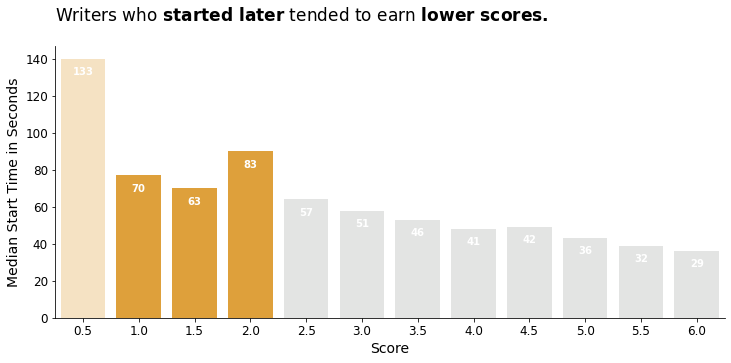

In [120]:
fig, ax = plt.subplots(figsize=(12, 5))

# Plotting the bars
ax = sns.barplot(x='score', y='first_input', palette =fi_palette, ci=None, data=start_end_df)

# Formatting the title and subtitle
title_text = 'Writers who ' + r"$\bf{" 'started \ later' "}$" +  ' tended to earn ' + r"$\bf{" 'lower \ scores.' "}$"
plt.title(title_text, loc='left', pad=25, fontsize=17)

r"$\bf{" 'higher \ event \ counts' "}$"

# Creating data labels
for p in ax.patches:
    height = (p.get_height()-7)
    width = p.get_width()
    ax.annotate(f'{height:.0f}', (p.get_x() + width/2, height), ha='center', va='center', color='white', weight='bold')
    
# Creating different transparency levels
for bar, alpha in zip(ax.containers[0], start_end_df['alpha']):
    bar.set_alpha(alpha)

# Formatting final attributes
plt.xlabel('Score', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Median Start Time in Seconds', fontsize=14)
plt.yticks(fontsize=12)
sns.despine()

plt.show()

### 2f. Input Types

Input creates a challenge because there are over 100 types of inputs, many of which occur very rarely. I focus on the input types that occur at least 100 times.

In [83]:
# Checking for the different input types

train_df['down_event'].unique()

array(['Leftclick', 'Shift', 'q', 'Space', 'Backspace', '.', ',', 'Enter',
       'ArrowLeft', "'", ';', 'ArrowRight', '-', '?', 'Tab', '"',
       'ArrowUp', 'ArrowDown', 'Rightclick', '=', 'CapsLock', 'Control',
       'c', 'v', '/', 'Delete', ':', 'z', '[', '$', '(', ')', '+', 'Home',
       'End', '\\', 'Meta', '*', '&', 'AudioVolumeMute', 'x', '!',
       'Insert', 'MediaPlayPause', 'NumLock', '%', 'V', '>', 'Alt',
       'AudioVolumeUp', 'ContextMenu', 'AudioVolumeDown', 'a', '<',
       'PageDown', ']', 'Middleclick', '@', 'F12', 'j', '\x96', 'Dead',
       't', 's', 'n', 'y', '{', 'ScrollLock', '¿', 'Process', '}',
       'MediaTrackPrevious', 'MediaTrackNext', 'F3', '^', 'Unidentified',
       'Cancel', '2', 'i', 'd', 'r', 'e', '`', '\x9b', 'm', '#', '~',
       'PageUp', 'T', 'A', 'b', 'S', 'ModeChange', '_', 'Escape', 'F11',
       'Unknownclick', 'AltGraph', 'F10', 'h', 'F15', 'Clear', 'OS', 'F',
       'C', 'o', 'Ä±', 'f', 'u', 'w', 'p', 'g', 'M', 'l', '|',
       'â\x80\x

In [84]:
# Checking how often each type occurs

train_df['down_event'].value_counts().head(25)

q               5365319
Space           1207128
Backspace        964089
Shift            334227
ArrowRight       121338
Leftclick         91126
ArrowLeft         63217
.                 59586
,                 46806
ArrowDown         30874
ArrowUp           28189
Enter             22689
CapsLock          12568
'                 11170
Delete            10965
Unidentified       6151
Control            4885
"                  4102
-                  3843
?                  3155
;                  1785
=                  1155
Tab                1081
/                   874
Rightclick          655
Name: down_event, dtype: int64

In [85]:
# Creating a variable to store the value counts

down_event_val_cnts = train_df['down_event'].value_counts()

In [86]:
# Filtering the counts to focus on events that occur at least 5 times

filtered_counts = down_event_val_cnts[down_event_val_cnts > 5]

In [87]:
len(filtered_counts)

90

In [88]:
# Converting the counts to a list of column names

target_columns = filtered_counts.index.to_list()
target_columns

['q',
 'Space',
 'Backspace',
 'Shift',
 'ArrowRight',
 'Leftclick',
 'ArrowLeft',
 '.',
 ',',
 'ArrowDown',
 'ArrowUp',
 'Enter',
 'CapsLock',
 "'",
 'Delete',
 'Unidentified',
 'Control',
 '"',
 '-',
 '?',
 ';',
 '=',
 'Tab',
 '/',
 'Rightclick',
 ':',
 '(',
 ')',
 '\\',
 'ContextMenu',
 'End',
 '!',
 'Meta',
 'Alt',
 '[',
 'c',
 'v',
 'NumLock',
 'Insert',
 'Home',
 'z',
 'AudioVolumeDown',
 'F2',
 'a',
 'x',
 'AudioVolumeUp',
 '$',
 '>',
 ']',
 '*',
 '%',
 '&',
 'Dead',
 's',
 'Escape',
 'ModeChange',
 'F3',
 '<',
 'AudioVolumeMute',
 '+',
 'F15',
 'ScrollLock',
 'Process',
 'PageDown',
 'i',
 't',
 '_',
 'PageUp',
 '`',
 '{',
 '#',
 '0',
 'Middleclick',
 '1',
 '5',
 'F12',
 '\x97',
 'e',
 '@',
 'OS',
 'F11',
 'r',
 'MediaTrackNext',
 'y',
 'm',
 'n',
 'Clear',
 'b',
 'o',
 'MediaPlayPause']

In [89]:
down_event_df = train_df.groupby(by='id')['down_event'].value_counts().unstack(fill_value=0)

In [90]:
# Filtering the dataframe for the selected columns

down_event_df = down_event_df[target_columns]

In [91]:
# Cleaning the dataframe for the merge

down_event_df['id'] = down_event_df.index
down_event_df.reset_index(drop=True,inplace=True)

In [92]:
full_df = pd.merge(full_df,down_event_df,on='id')
full_df

,id,score,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time,action_time_%_total,word_count,total_words,...,F11,r,MediaTrackNext,y,m,n,Clear,b,o,MediaPlayPause
0,001519c8,3.5,297243,116.246774,91.797374,0,2259,0.165135,255,348.0,...,0,0,0,0,0,0,0,0,0,0
1,0022f953,3.5,275391,112.221271,55.431189,0,1758,0.152995,320,369.0,...,0,0,0,0,0,0,0,0,0,0
2,0042269b,6.0,421201,101.837766,82.383766,0,3005,0.234001,404,549.0,...,0,0,0,0,0,0,0,0,0,0
3,0059420b,2.0,189596,121.848329,113.768226,0,806,0.105331,206,244.0,...,0,0,0,0,0,0,0,0,0,0
4,0075873a,4.0,313702,123.943896,62.082013,0,701,0.174279,252,339.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,105.437856,63.622575,0,3323,0.277594,273,620.0,...,0,0,0,0,0,0,0,0,0,0
2467,ffbef7e5,4.0,214221,82.266129,36.178818,0,1144,0.119012,438,450.0,...,0,0,0,0,0,0,0,0,0,0
2468,ffccd6fd,1.5,231580,75.605615,63.494975,0,564,0.128656,201,213.0,...,0,0,0,0,0,0,0,0,0,0
2469,ffec5b38,5.0,289439,89.277915,54.515788,0,1388,0.160799,413,472.0,...,0,0,0,0,0,0,0,0,0,0


### 2g. Pauses

I count pauses as events between down events lasting 5 seconds or more. I create features for the number of pauses and the total time spent on pauses.

In [93]:
# Creating a function to include a feature for the previous downtime

def add_previous_down_time(group):
    group['previous_down_time'] = group['down_time'].shift(1).fillna(group['down_time'])
    return group[['id','down_time','previous_down_time']]

In [94]:
# Applying the function to each essay

pause_df = train_df.groupby('id').apply(add_previous_down_time)

In [95]:
pause_df['down_time_difference'] = pause_df['down_time'] - pause_df['previous_down_time']
pause_df['pauses'] = 0
pause_df.loc[pause_df['down_time_difference']>=5000,'pauses'] = 1

In [96]:
pause_df['pause_time'] = 0
pause_df.loc[pause_df['down_time_difference']>=5000,'pause_time'] = pause_df['down_time_difference']

In [97]:
pause_df = pause_df.reset_index(drop=True)
pause_df = pause_df[['id','pauses','pause_time']]
pause_df = pause_df.groupby('id').sum()

In [98]:
pause_df

,pauses,pause_time
id,,
001519c8,64,990349.0
0022f953,47,1078925.0
0042269b,34,984197.0
0059420b,30,600419.0
0075873a,49,922116.0
...,...,...
ffb8c745,24,920566.0
ffbef7e5,42,821360.0
ffccd6fd,34,980387.0


In [99]:
pause = pause_df.groupby(by='id')
pause_features = pause.agg({
        'pauses': ['sum'], 
        'pause_time': ['sum', 'mean', 'min', 'max'],                                           
    })

In [100]:
pause_features.columns = ['_'.join(col).strip() for col in pause_features.columns.values]

In [101]:
pause_features.reset_index(inplace=True)
pause_features

,id,pauses_sum,pause_time_sum,pause_time_mean,pause_time_min,pause_time_max
0,001519c8,64,990349.0,990349.0,990349.0,990349.0
1,0022f953,47,1078925.0,1078925.0,1078925.0,1078925.0
2,0042269b,34,984197.0,984197.0,984197.0,984197.0
3,0059420b,30,600419.0,600419.0,600419.0,600419.0
4,0075873a,49,922116.0,922116.0,922116.0,922116.0
...,...,...,...,...,...,...
2466,ffb8c745,24,920566.0,920566.0,920566.0,920566.0
2467,ffbef7e5,42,821360.0,821360.0,821360.0,821360.0
2468,ffccd6fd,34,980387.0,980387.0,980387.0,980387.0
2469,ffec5b38,30,638164.0,638164.0,638164.0,638164.0


In [102]:
full_df = pd.merge(full_df,pause_features,on='id')

In [103]:
full_df['characters_per_pause'] = full_df['q'] / full_df['pauses_sum']
full_df.loc[full_df['pauses_sum']==0,'characters_per_pause'] = full_df['q']
full_df['action_time_per_pause'] = full_df['sum_action_time'] / full_df['pauses_sum']
full_df.loc[full_df['pauses_sum']==0,'action_time_per_pause'] = full_df['sum_action_time']
full_df['action_time_per_pause_time'] = full_df['sum_action_time'] / full_df['pause_time_sum']
full_df.loc[full_df['pause_time_sum']==0,'action_time_per_pause_time'] = full_df['sum_action_time']

### 2i. Sentence Length

Now that I have all of the information from the logs that I want to use in my model in the full dataframe, I construct some additional features for the model to use. First, I approximate sentence length by dividing the final word count by the number of periods in the essay. Sentence length can indicate sophisticated sentence structure. It can also indicate run-on sentences.

In [104]:
full_df['end_punctuation'] = full_df['.'] + full_df['!'] + full_df['?']
full_df['sentence_length'] = full_df['total_words'] / full_df['end_punctuation']
full_df.loc[(full_df['end_punctuation']==0),'sentence_length'] = full_df['total_words']

In [105]:
full_df['events_per_word'] = full_df['event_count'] / full_df['word_count']
full_df.loc[full_df['word_count']==0,'events_per_word'] = full_df['event_count']

In [106]:
full_df['characters_per_word'] = full_df['q'] / full_df['total_words']
full_df.loc[full_df['total_words']==0,'characters_per_word'] = full_df['q']

In [107]:
full_df.isnull().sum().sum()

0

### 2j. Preprocessing Function

I combine all of these steps into a single function so that I can preprocess unseen data without having to repeat all of the previous steps.

In [108]:
def preprocess(log_df):
    
    # Action Time
    action_time = log_df.groupby(by='id')['action_time'].sum()
    action_time_df = pd.DataFrame({'id':action_time.index, 'action_time':action_time.values})
    action_time_df['action_time'] = action_time_df['action_time']
    action_time_df['action_time_%_total'] = action_time_df['action_time'] / 1800000
    
    # Final Word Count
    final_word_count = log_df.groupby('id')['word_count'].last()
    word_count_df = pd.DataFrame({'id':final_word_count.index,'word_count':final_word_count.values})
    final_record_id_series = log_df.groupby('id')['event_id'].last()
    final_record_ids = final_record_id_series.to_dict()
    
    def total_words(group):
        final_record_id = final_record_ids[group.name]
        word_counts = group[group['event_id'] <= final_record_id]['word_count']
        word_diffs = word_counts.diff().where(lambda x: x > 0).sum()  
    
        return word_diffs
    
    total_words = log_df.groupby('id').apply(total_words)
    total_words_df = pd.DataFrame({'id':total_words.index,'total_words':total_words.values})
    word_count_df = pd.merge(word_count_df, total_words_df, on='id')
    
    # Final Event Count
    event_count = log_df.groupby('id')['event_id'].last()
    event_count_df = pd.DataFrame({'id':event_count.index,'event_count':event_count.values})
    
    # Activity
    activities = ['Input', 'Move', 'Nonproduction', 'Paste', 'Remove/Cut', 'Replace']
    
    log_df.loc[log_df['activity'].str.contains('From',case=False), 'activity'] = 'Move'
    log_df.loc[log_df['activity'].str.contains('From',case=False), 'activity'] = 'Move'
    activity_data = log_df.groupby(by='id')['activity'].value_counts().unstack(fill_value=0)
    
    for activity in activities:
        if activity in activity_data.columns:
            activity_data[activity] = activity_data[activity]
        else:
            activity_data[activity] = 0
    
    activity_df = activity_data.reset_index(inplace=True)
    
    pivot = log_df.pivot_table(values='action_time', index='id', columns='activity', aggfunc=['sum']).fillna(0)
    pivot.columns = pivot.columns.droplevel(level=0)
    
    for activity in activities:
        if activity in pivot.columns:
            pivot[activity] = pivot[activity]
        else:
            pivot[activity] = 0
    
    new_columns = [col + '_time' for col in pivot.columns]
    pivot.columns = new_columns
    pivot.reset_index(inplace=True)
    
    # Time of First and Last Input
    first_input = log_df[log_df['activity'] == 'Input'].groupby('id').first()
    first_input_df = pd.DataFrame({'id':first_input.index,'first_input':first_input['down_time']})
    first_input_df.reset_index(drop=True,inplace=True)
    last_input = log_df[log_df['activity'] == 'Input'].groupby('id').last()
    last_input_df = pd.DataFrame({'id':last_input.index,'last_input':last_input['up_time']})
    last_input_df.reset_index(drop=True,inplace=True)
    first_last_input_df = pd.merge(first_input_df,last_input_df,on='id')
    
    # Inputs
    columns = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',',
               'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified', 'Control',
               '"', '-', '?', ';', '=', 'Tab', '/', 'Rightclick', ':', '(', ')', '\\', 'ContextMenu',
               'End', '!', 'Meta', 'Alt', '[', 'c', 'v', 'NumLock', 'Insert', 'Home', 'z', 'AudioVolumeDown',
               'F2', 'a', 'x', 'AudioVolumeUp', '$', '>', ']', '*', '%', '&', 'Dead', 's', 'Escape',
               'ModeChange', 'F3', '<', 'AudioVolumeMute', 'F15', '+', 'ScrollLock', 'Process', 'PageDown',
               't', 'i', '_', '`', 'PageUp', '{', '0', '#', 'Middleclick', '1', '5', 'F12', '\x97',
               'OS', 'e', '@', 'F11', 'r', 'MediaTrackNext', 'y', 'm', 'n', 'b', 'Clear', 'MediaPlayPause', 'o']
    
    down_event_data = log_df.groupby(by='id')['down_event'].value_counts().unstack(fill_value=0)
    
    for col in columns:
        if col in down_event_data.columns:
            down_event_data[col] = down_event_data[col]
        else:
            down_event_data[col] = 0
    
    down_event_df = down_event_data[columns]
    down_event_df.reset_index(inplace='True')
    
            
    # Pauses
    def add_previous_down_time(group):
        group['previous_down_time'] = group['down_time'].shift(1).fillna(group['down_time'])
        return group[['id','down_time','previous_down_time']]

    pause_df = log_df.groupby('id').apply(add_previous_down_time)
    
    pause_df['down_time_difference'] = pause_df['down_time'] - pause_df['previous_down_time']
    pause_df['pauses'] = 0
    pause_df.loc[pause_df['down_time_difference']>=5000,'pauses'] = 1
    
    pause_df['pause_time'] = 0
    pause_df.loc[pause_df['down_time_difference']>=5000,'pause_time'] = pause_df['down_time_difference']
    
    pause_df = pause_df.reset_index(drop=True)
    pause_df = pause_df[['id','pauses','pause_time']]
    pause_df = pause_df.groupby('id').sum()
    
    # Merge DataFrames
    full_df = pd.merge(action_time_df, word_count_df, on = 'id')
    full_df = pd.merge(full_df, pivot, on = 'id')
    full_df = pd.merge(full_df, event_count_df, on = 'id')
    full_df = pd.merge(full_df, activity_df, on = 'id')
    full_df = pd.merge(full_df, first_last_input_df, on = 'id')
    full_df = pd.merge(full_df, down_event_df, on = 'id')
    full_df = pd.merge(full_df, pause_df, on = 'id')
    
    # Sentence Length
    full_df['end_punctuation'] = full_df['.'] + full_df['!'] + full_df['?']
    full_df['sentence_length'] = full_df['word_count'] / full_df['end_punctuation']
    full_df.loc[full_df['end_punctuation']==0,'sentence_length'] = full_df['word_count']
    
    # Ratios
    full_df['Move_Ratio'] = full_df['Move'] / full_df['event_count']
    full_df['Paste_Ratio'] = full_df['Paste'] / full_df['event_count']
    full_df['Replace_Ratio'] = full_df['Replace'] / full_df['event_count']
    full_df['Nonproduction_Ratio'] = full_df['Nonproduction'] / full_df['event_count']
    full_df['Remove_Ratio'] = full_df['Remove/Cut'] / full_df['event_count']
    full_df['Input_Ratio'] = full_df['Input'] / full_df['event_count']
    full_df['revision_events'] = full_df['Move'] + full_df['Paste'] + full_df['Replace'] + full_df['Remove/Cut']
    full_df['Revision_Ratio'] =  full_df['revision_events'] / full_df['event_count']
    full_df['characters_per_pause'] = full_df['q'] / full_df['pauses']
    full_df.loc[full_df['pauses']==0,'characters_per_pause'] = full_df['q']
    full_df['Move_Time_Ratio'] = full_df['Move_time'] / full_df['action_time']
    full_df['Paste_Time_Ratio'] = full_df['Paste_time'] / full_df['action_time']
    full_df['Replace_Time_Ratio'] = full_df['Replace_time'] / full_df['action_time']
    full_df['Nonproduction_Time_Ratio'] = full_df['Nonproduction_time'] / full_df['action_time']
    full_df['Remove_Time_Ratio'] = full_df['Remove/Cut_time'] / full_df['action_time']
    full_df['Input_Time_Ratio'] = full_df['Input_time'] / full_df['action_time']
    full_df['revision_time'] = full_df['Move_time'] + full_df['Paste_time'] + full_df['Replace_time'] + full_df['Remove/Cut_time']
    full_df['Revision_Time_Ratio'] =  full_df['revision_time'] / full_df['action_time']
    full_df['action_time_per_pause'] = full_df['action_time'] / full_df['pauses']
    full_df.loc[full_df['pauses']==0,'action_time_per_pause'] = full_df['action_time']
    full_df['action_time_per_pause_time'] = full_df['action_time'] / full_df['pause_time']
    full_df.loc[full_df['pause_time']==0,'action_time_per_pause_time'] = full_df['action_time']
    
    return full_df